<a href="https://colab.research.google.com/github/hirokiyokoyama/gan_workshop/blob/master/gan_workshop_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 敵対的生成ネットワーク研究会
第一回のURL：
https://colab.research.google.com/drive/1egFCcIXzM7xtlXWRp9wFjDSocL5j94oP

第二回のURL：
https://colab.research.google.com/drive/1t_QRi-V77uqIvJIhqvtwUVYOcsKZmK_A

Slackに参加：
https://join.slack.com/t/gan-workshop/shared_invite/enQtNzc0MzQ0NzQxODczLTA1NGNjNzM4OWRmN2U5OTYyNjM0YWE3MGQ1Mjk1YmM2YWYzNjExZTBkYjAzNTNiYWNmMWQzYWIzZmVmMjJiY2I

横山のgithub（こちらにもノートブックが置いてあります）
https://github.com/hirokiyokoyama/gan_workshop


In [0]:
#@title 今回使うものの準備

# GPUを用いて高速に実行できる機械学習ライブラリ
import tensorflow as tf
tf.enable_eager_execution()

# 結果をプロットするためのライブラリ
import matplotlib.pyplot as plt

import numpy as np
layers = tf.keras.layers

# 学習の安定のため、中間層の値を正規化するLayer
class PixelwiseNormalization(tf.keras.layers.Layer):
  def __init__(self):
    super(PixelwiseNormalization, self).__init__()
  
  def call(self, x):
    n = tf.reduce_mean(tf.square(x), -1, keepdims=True)
    n = tf.rsqrt(n + 1e-5)
    return x * n

# ミニバッチ内の特徴量の標準偏差をdiscriminatorの判別基準にするためのLayer
# これによって本物の特徴量が多様ならば、偽物の特徴量も多様になるようにgeneratorが学習するようになる（mode collapse防止）
# Discriminatorの最終層の手前などに入れて使う
class MinibatchStddev(tf.keras.layers.Layer):
  def __init__(self, group_size=1, num_new_features=1):
    super(MinibatchStddev, self).__init__()
    self._group_size = group_size
    self._num_new_features = num_new_features

  def call(self, x):
    s = tf.shape(x) # [NHWC]  Input shape.
    n = self._num_new_features
    G = tf.minimum(self._group_size, s[0])

    # [GMHWnc] Split minibatch into M groups of size G. Split channels into n channel groups c.
    y = tf.reshape(x, [G, -1, s[1], s[2], n, s[3]//n])
    # [MHWnc]  Calc stddev over group.
    y -= tf.reduce_mean(y, axis=0, keepdims=True)
    y = tf.reduce_mean(tf.square(y), axis=0)
    y = tf.sqrt(y + 1e-8)
    # [M11n]  Take average over fmaps and pixels.
    y = tf.reduce_mean(y, axis=[1,2,4], keepdims=True)[:,:,:,:,0]
    # [NHWn]  Replicate over group and pixels.
    y = tf.tile(y, [G, s[1], s[2], 1])
    # [NHWC]  Append as new fmap.
    return tf.concat([x, y], axis=3)

# 畳み込み層ごとの学習率を最適化するための細工 (Karras et al., 2018)
class Conv2D(layers.Conv2D):
  def __init__(self, *args, **kwargs):
    kwargs['kernel_initializer'] = tf.keras.initializers.RandomNormal(stddev=1.)
    super(Conv2D, self).__init__(*args, **kwargs)

  def build(self, input_shape):
    super(Conv2D, self).build(input_shape)
    shape = self.kernel.shape.as_list()
    self._normalization_constant = np.sqrt(2./(shape[0] * shape[1] * shape[2]))
  
  def call(self, x):
    x = x * self._normalization_constant
    x = super(Conv2D, self).call(x)
    return x

In [0]:
#@title データセットの準備

# 画像のチャネル数（MNIST、Fashion-MNISTは1、カラー画像は3）
input_channels = 1

#Fashion-MNIST データセット
import tensorflow_datasets as tfds
#ds = tfds.image.mnist.FashionMNIST()
ds = tfds.image.mnist.MNIST()
ds.download_and_prepare()
dataset = ds.as_dataset()['train']
def preprocess(data):
  img = tf.cast(data['image'], tf.float32)/255. * 2. - 1. #黒を-1.0、白を+1.0とする
  return tf.image.resize_bilinear([img], (16, 16))[0], data['label']
dataset = dataset.map(preprocess)

# 敵対的生成ネットワーク（Generative Adversarial Networks; GAN）

乱数から画像を生成するgeneratorと、画像が本物か偽物かを判別するdiscriminatorが、互いに敵対するように構成されたネットワーク。

### GANの研究開発に必要なもの
- 機械学習の基礎知識
- 人工ニューラルネットワークの知識
- 計算リソース（GPUやそれを動かすためのフレームワークなど、今回はGoogle Colaboratory+TensorFlow）
- GANの知識（今回の内容）

### 用語集
|用語（呼び方）|記号（数式）|説明|
|:--|:--|:--|
| real、本物 | $x$ | データセットから取り出される「本物」の画像 |
| noise、乱数 | $z$ | Generatorに入力される乱数、常に乱数とは限らないので、隠れ変数（latent variable）とも |
| generator、生成器 | $G$ | 乱数を入力とし画像を出力とする関数 |
| discriminator、判別器 | $D$ | 画像を入力としスカラーを出力とする関数 |
| fake、偽物 | $G(z)$ | Generatorが生成する「偽物」の画像 |
|判別値、本物度| $D(x), D(G(z))$ | Discriminatorが表現する、画像の「本物度」 |

### 今までの目的関数（おさらい）
- 二次関数（単純に極小点に収束するという例でした）
- 二つの関数の距離（一方はサンプルを生成している真の関数、もう一方はパラメータで表現した関数、後者を前者に「フィッティング」する）
- クロスエントロピー（識別問題を関数のフィッティングとみたときの、二つの関数の距離のようなもの）

### GANにおける二つの目的関数
- Discriminatorの目的関数：Realの本物度は大きく、fakeの本物度は小さく。クロスエントロピーとほぼ同じ。
- Generatorの目的関数：Fakeの本物度を大きくして、discriminatorを「騙そう」とする。こちらは関数のフィッティングとは少し異なる。

同じ関数を一方では大きく、もう一方では小さくしようとするので敵対的（adversarial）。

# Generator

機械学習はランダムに初期化された関数から初めて、目的関数を設定して勾配法によって良くして行く、という方法を取るので、とにかく入力からどのようにして出力を計算するか（フォワード経路）をまず考える。フォワード経路と目的関数さえ決めれば、勾配の計算（バックワード経路）とパラメータの更新はTensorFlowに任せられる。

第一回の識別ネットワークと異なり、出力が画像となるので、幅と高さを大きくして行く方針を考える。画像の場合、チャネル数は最終的に１（グレースケール）か３（RGB）まで減らして行く。
1. n個の乱数を生成（幅1、高さ1、チャネル数nの特徴マップと考える）
2. 何回か畳み込み（Conv2D）を行う
3. 各ピクセルを2x2ピクセルにコピーすることで、幅、高さをそれぞれ2倍にする（UpSampling2D）
4. 目的の画像サイズになるまで2と3を繰り返す
5. 各点ごとに目的のチャネル数（グレースケールなら1、RGBなら3）になるように1x1のカーネルで畳み込み（Conv2D）を行う
6. ハイパボリックタンジェント（tanh）を使って出力値を(-1,+1)の範囲に制約する


In [0]:
#@title ハイパボリックタンジェント
x = tf.linspace(-5.,5.,100)
y = tf.tanh(x)
plt.plot(x, y);

In [0]:
noise_dim = 128

generator = tf.keras.Sequential([
    Conv2D(256, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(128, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(64, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(32, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    layers.UpSampling2D(2),
    Conv2D(16, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    PixelwiseNormalization(),

    Conv2D(input_channels, [1,1], 1, 'SAME', use_bias=True),
    layers.Activation('tanh')
  ])

##とにかく画像を学習させてみる（画像の丸暗記）

畳み込みニューラルネットワークは画像を出力できるか？まずは関数のフィッティングで学習して確認してみる。

入力が128次元なので、128個の単位ベクトル（$(1,0,\cdots,0), (0,1,0,\cdots,0),\cdots$）に128枚の適当な画像を対応づけてみる。
目的関数はgeneratorが生成した画像と正解画像との二乗誤差（mean squared error）。

In [0]:
generator.compile(tf.train.AdamOptimizer(0.001), loss='mean_squared_error')

inputs = tf.one_hot(tf.range(noise_dim), noise_dim) # tf.one_hot(i)はe[i]だけ1.で他が0.のベクトル（つまり単位ベクトル）を生成
inputs = tf.reshape(inputs, [noise_dim, 1, 1, noise_dim])
for x, y in dataset.batch(noise_dim).take(1):
  image = x

In [0]:
generator.fit(x=inputs, y=image, epochs=1000, verbose=0)

In [0]:
#@title 正解画像と生成画像を比較
y = generator(inputs)
plt.figure(figsize=(15,5))
n = 10
for i in range(n):
  plt.subplot(2,n,i+1)
  plt.imshow(image[i,:,:,0])
  plt.axis('off')
  plt.subplot(2,n,n+i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

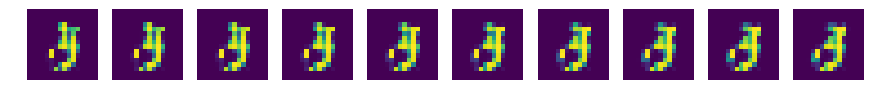

In [0]:
#@title 入力を徐々に変化させてみる
import numpy as np
i1 = 0
i2 = 1
n = 10

x = np.zeros([n,1,1,noise_dim], np.float32)
x[:,0,0,i1] = np.linspace(0.,1.,n)
x[:,0,0,i2] = np.linspace(1.,0.,n)
y = generator(tf.constant(x))
plt.figure(figsize=(15,5))
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

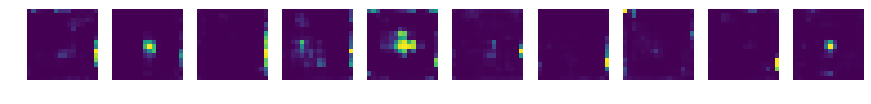

In [0]:
#@title 任意の乱数について意味のある画像を生成できるか？
n = 10
y = generator(tf.random.normal([n,1,1,noise_dim]))
plt.figure(figsize=(15,5))
for i in range(n):
  plt.subplot(1,n,i+1)
  plt.imshow(y[i,:,:,0])
  plt.axis('off')

- 128次元のベクトルを入力して画像を出力する関数が畳み込みニューラルネットワーク（CNN）で実現できた
- このCNN単体でGANの機能を学習することはできない
- この後discriminatorを構築し、GANのgeneratorとして動作させる

# Discriminator

Discriminatorは入力画像がデータセットから選ばれたもの（real）か、generatorが生成したもの（fake）かを学習する。
Discriminator自体の学習は2クラスの分類問題となるので、前回の分類機と基本的に同じ。ただし、2クラスの場合、出力は一つの数値で良い。何故ならば、realであれば出力値を大きく、fakeであれば出力値を小さくすれば判別できるため。

Generatorでは$1\times1$の特徴マップ（入力乱数）から始めて、縦横を2倍にする演算（UpSampling2D）を繰り返すことで、一定サイズの画像を生成した。Discriminatorではこれと対称的に、縦横を半分にする演算（AveragePooling2D）を繰り返して特徴マップを小さくして行く方針をとる。

1. $m\times m \times c$の画像を入力（cは画像のチャネル数）
2. $1\times1$のカーネルで畳み込んで$m\times m \times C$とする
3. 何層かの畳み込み層（Conv2D）を計算
4. 2x2ピクセルの領域ごとに平均をとることで、幅、高さをそれぞれ半分にする（AveragePooling2D）
5. 特徴マップのサイズが$1\times 1$になるまで3と4を繰り返す
5. 判別値はスカラーなので、チャネル数が1になるように1x1のカーネルで畳み込み（Conv2D）を行う

Generatorとdiscriminatorの構造は必ずしも対称的である必要はないが、対称的にされることが多い。


In [0]:
discriminator = tf.keras.Sequential([
    Conv2D(16, [1,1], 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),

    Conv2D(32, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),
    
    Conv2D(64, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),
    
    Conv2D(128, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),

    Conv2D(256, 3, 1, 'SAME', use_bias=True),
    layers.LeakyReLU(0.2),
    layers.AveragePooling2D(2),

    Conv2D(1, 3, 1, 'SAME', use_bias=False)
])

##本物と偽物を判別させてみる

In [0]:
discriminator.compile(tf.train.AdamOptimizer(0.001), loss='binary_crossentropy')

for x, y in dataset.batch(10000).take(1):
  real = x
fake = generator(tf.random.normal([10000,1,1,noise_dim]))
inputs = tf.concat([real, fake], 0)
outputs = tf.concat([tf.ones([10000,1,1,1]), tf.zeros([10000,1,1,1])], 0)

In [0]:
discriminator.fit(x=inputs, y=outputs, epochs=10, verbose=0)

In [0]:
#@title Discriminatorの出力
for x, y in dataset.batch(1000).take(1):
  d_real = discriminator(x)
  d_fake = discriminator(generator(tf.random.normal([1000,1,1,noise_dim])))
  plt.hist(d_real[:,0,0,0], label='real')
  plt.hist(d_fake[:,0,0,0], label='fake')

# Generatorとdiscriminatorを戦わせる

上のセルでは、discriminator（$D$）は、$D(x)$を大きくするように、$D(G(z))$を小さくするように学習している。これにより、$D$の値の大小で本物と偽物を見分けることができる。
逆に、$D(G(z))$を大きくするような$G(z)$をgenerator（$G$）が生成できれば、それはdiscriminatorを騙したという意味で本物らしいということになる。
ここで、discriminatorを再び学習させれば、本物らしくなった$G(z)$と$x$を見分けられるように判断基準を変えることになる。このとき、generatorは$D(G(z))$を大きくするために、その新たな判断基準でも見分けられないような$G(z)$を生成するように学習することになり…

そこで、discriminatorが$D(x)$を大きく、$D(G(z))$を小さくするようにしながら、同時にgeneratorが$D(G(z))$を大きくするように学習することで、generatorとdiscriminatorが切磋琢磨しながら互いの精度を向上させて行くということが期待できる。これがGANの基本的な仕組みである。

In [0]:
def f(x):
  return x

# クロスエントロピーでフィッティングする場合
#def f(x):
#  return -tf.log1p(tf.exp(-x))

@tf.contrib.eager.defun #これをつけた関数は最初の呼び出し時に最適化される
def train_step(real, noise):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake = generator(noise)

    d_real = discriminator(real)
    d_fake = discriminator(fake)

    loss = f(d_real) + f(-d_fake)
    g_loss = tf.reduce_mean(loss)
    d_loss = tf.reduce_mean(-loss)

  g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
  d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
  g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
  d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
  return d_loss

g_opt = tf.train.AdamOptimizer(0.0002)
d_opt = tf.train.AdamOptimizer(0.0002)
epoch = 0

In [0]:
import time

for i in range(5):
  t0 = time.time()
  for x, y in dataset.shuffle(1000).batch(128):
    loss = train_step(x, tf.random.normal([x.shape[0],1,1,noise_dim]))
  t1 = time.time()
  print("Epoch {}: loss={}, took {} sec.".format(epoch, loss.numpy(), t1-t0))
  epoch += 1

In [0]:
#@title バックグラウンドで実行

import time
import threading

def train():
  for i in range(5):
    t0 = time.time()
    for x, y in dataset.shuffle(1000).batch(128):
      loss = train_step(x, tf.random.normal([x.shape[0],1,1,noise_dim]))
    t1 = time.time()
    print("Epoch {}: loss={}, took {} sec.".format(epoch, loss.numpy(), t1-t0))
    epoch += 1

thread = threading.Thread(target=train)
thread.start()

# Mode collapse

上記のように構成したGANは、確かに任意の乱数について手書き数字に見える画像を生成するが、全てが「１」であったりして、MNISTの画像を網羅しているとは言い難い。
これはmode collapseと呼ばれる現象で、GANの分野では中心的とも言える大きな問題になっている。

Mode collapseについて考えるためには、データセットに含まれる画像がどのように「分布」しているのかを理解する必要がある。
例えば、MNISTの「１」にはバリエーションがあり、傾きや線の太さが異なるが、
画像としては互いに似ていて、ある「１」から別の「１」まで滑らかに変化されることができる。
一方、「１」から「０」へ滑らかに変化させることはできない。
したがって、MNISTに含まれる画像の分布は、いくつかの「島」から成っていると考えられる。
この「島」（の頂点）をmodeと呼ぶ。Mode collapseは、generatorが一部の「島」に属する画像を全く生成しないように学習してしまう現象。

Mode collapseの原因の一つに、discriminatorの学習のし過ぎがある。
Discriminatorの学習が進むと、「島」の内部では$D$の値が大きく、外部では$D$の値が小さくなる。Generatorは$D$の傾きを見ながら入島を目指すのだが、discriminatorが「島」の内外をあまりはっきりと区別してしまうと、「島」から離れたところでは$D$の値が常に小さく、どちらに行けば「島」に近づけるのかわからなくなる。
たまたまいくつかの「島」に入っていれば、もはやその「島」からは出ることができず、他の「島」の探索はできなくなる。
直感的に言えば、discriminatorがやっとのことで偽物の判別をしていれば、generatorはその判断基準を読んで今後の偽物品質を向上することができるが、
discriminatorがあまりにも余裕綽々と判別をしてしまうと、generatorにはその判断基準が想像もつかなくなり、現状の偽物をどのように改良すればよいかわからなくなってしまう。

初期に提案されたGANの手法は、ほとんどこのmode collapseの対策と言ってもいいほどで、これまでに様々な対策が提案されている。
多くの手法で共通する方針は、discriminatorの判断基準を「緩やか」にするというもので、
$D$の値が「島」の境界で急激に大きくなることを防ぎ、「島」から離れたところにも情報（$D$の傾き、すなわち判断基準）が届くようにする。
今回はその方針に従っているものの中で実装が比較的簡単なquadratic potential（[Su, 2018](https://arxiv.org/pdf/1811.07296.pdf)）を適用してみる。

In [0]:
# Dの傾きを求める
# これを小さくするようにdiscriminatorに制約をかける
def quadratic_potential(dx, dy, _lambda=.01, _epsilon=1e-8, norm='L2'):
  norm = norm.lower()
  if norm == 'l1':
    dx = tf.abs(dx)
  elif norm == 'l2':
    dx = tf.square(dx)
  else:
    raise ValueError('Unknown norm type: {}'.format(norm))

  dx = tf.reduce_mean(tf.reshape(dx, [tf.shape(dx)[0],-1]))
  if norm == 'l2':
    dx = tf.sqrt(dx)

  return tf.square(dy)/(dx*2*_lambda + _epsilon)

@tf.contrib.eager.defun #これをつけた関数は最初の呼び出し時に最適化される
def train_step(real, noise):
  with tf.GradientTape() as g_tape, tf.GradientTape() as d_tape:
    fake = generator(noise)

    d_real = discriminator(real)
    d_fake = discriminator(fake)

    loss = f(d_real) + f(-d_fake)
    g_loss = tf.reduce_mean(loss)
    d_loss = tf.reduce_mean(-loss + quadratic_potential(fake-real, d_fake-d_real))

  g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
  d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
  g_opt.apply_gradients(zip(g_grads, generator.trainable_variables))
  d_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))
  return d_loss

epoch = 0
g_opt = tf.train.AdamOptimizer(0.0002)
d_opt = tf.train.AdamOptimizer(0.0002)

# 課題
- ネットワーク構造をいじってみる
  - チャネル数を増やしたらどうなる？
  - カーネルのサイズを大きくしたらどうなる？
  - 畳み込み層を増やしたらどうなる？
- 学習率を変えてみる
- Quadratic potentialの係数$\lambda$(lambda)を変えてみる
- データセットを変えてみる
  - 「３」だけ学習させてみる
  - Fashion MNISTにしてみる
  - その他、カラーのデータセット（CIFARなど）にしてみる
- 学習による生成画像の変化を追ってみる
- 色々な画像の間を補間してみる

In [0]:
#@title Googleドライブにgeneratorを保存

from google.colab import drive
drive.mount('/gdrive')

generator.save_weights('/gdrive/My Drive/gan_workshop/generator')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [0]:
#@title Googleドライブからgeneratorを読み込み

from google.colab import drive
drive.mount('/gdrive')

generator.load_weights('/gdrive/My Drive/gan_workshop/generator')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
